In [1]:
%matplotlib inline

Visualization of Convolutional Neural Networks: VGG16
=============
We are going to show input images that minimize the loss of a convolution network for a specific layer and filter.

In [2]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torchvision import models
from torchsummary import summary

In [3]:
# Some utility functions: format_np_output, save_image, preprocess_image, recreate_image
def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((224, 224))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


In [4]:
# Define the CNNLayerVisualization and save the generated input image of size (224,224,3)
from torch.optim import Adam

class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('./generated'):
            os.makedirs('./generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = './generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = './generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

In [5]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#use_gpu = torch.cuda.is_available()

#device = torch.device("cuda" if use_gpu else "cpu")
#print(device)

# Fully connected layer is not needed
pretrained_model = models.vgg16(pretrained=True).features #.to(device)

In [6]:
summary(pretrained_model, input_size=(3, 224, 224),device='cpu') 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [7]:
cnn_layer = 2
filter_pos = 24
    
# Fully connected layer is not needed
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

Iteration: 1 Loss: -0.19
Iteration: 2 Loss: -0.31
Iteration: 3 Loss: -0.46
Iteration: 4 Loss: -0.61
Iteration: 5 Loss: -0.76
Iteration: 6 Loss: -0.91
Iteration: 7 Loss: -1.07
Iteration: 8 Loss: -1.23
Iteration: 9 Loss: -1.40
Iteration: 10 Loss: -1.58
Iteration: 11 Loss: -1.77
Iteration: 12 Loss: -1.96
Iteration: 13 Loss: -2.16
Iteration: 14 Loss: -2.37
Iteration: 15 Loss: -2.58
Iteration: 16 Loss: -2.80
Iteration: 17 Loss: -3.02
Iteration: 18 Loss: -3.25
Iteration: 19 Loss: -3.49
Iteration: 20 Loss: -3.72
Iteration: 21 Loss: -3.96
Iteration: 22 Loss: -4.21
Iteration: 23 Loss: -4.46
Iteration: 24 Loss: -4.70
Iteration: 25 Loss: -4.96
Iteration: 26 Loss: -5.21
Iteration: 27 Loss: -5.46
Iteration: 28 Loss: -5.72
Iteration: 29 Loss: -5.98
Iteration: 30 Loss: -6.24


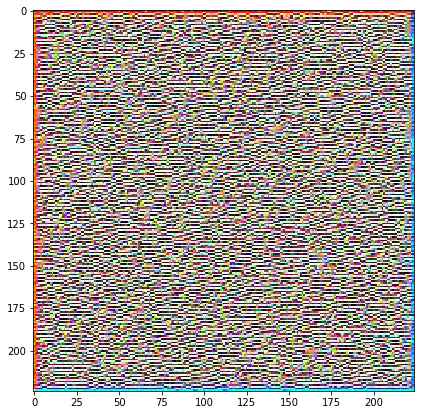

In [8]:
im_path = './generated/layer_vis_l' + str(cnn_layer) + \
                    '_f' + str(filter_pos) + '_iter' + str(30) + '.jpg'
img = Image.open(im_path)
plt.figure(figsize=(7,7))
plt.imshow(img)

In [9]:
cnn_layer = 17
filter_pos = 5
    
# Fully connected layer is not needed
#pretrained_model = models.vgg16(pretrained=True).features

layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
# layer_vis.visualise_layer_without_hooks()

Iteration: 1 Loss: 1.35
Iteration: 2 Loss: -1.83
Iteration: 3 Loss: -8.28
Iteration: 4 Loss: -15.32
Iteration: 5 Loss: -21.91
Iteration: 6 Loss: -28.18
Iteration: 7 Loss: -34.18
Iteration: 8 Loss: -39.87
Iteration: 9 Loss: -45.40
Iteration: 10 Loss: -50.77
Iteration: 11 Loss: -56.08
Iteration: 12 Loss: -61.27
Iteration: 13 Loss: -66.42
Iteration: 14 Loss: -71.51
Iteration: 15 Loss: -76.53
Iteration: 16 Loss: -81.56
Iteration: 17 Loss: -86.56
Iteration: 18 Loss: -91.54
Iteration: 19 Loss: -96.51
Iteration: 20 Loss: -101.48
Iteration: 21 Loss: -106.47
Iteration: 22 Loss: -111.45
Iteration: 23 Loss: -116.44
Iteration: 24 Loss: -121.43
Iteration: 25 Loss: -126.45
Iteration: 26 Loss: -131.49
Iteration: 27 Loss: -136.55
Iteration: 28 Loss: -141.61
Iteration: 29 Loss: -146.71
Iteration: 30 Loss: -151.85


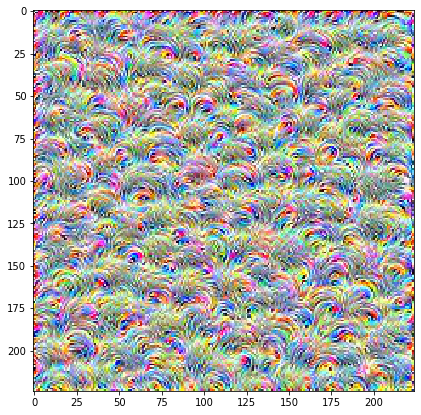

In [10]:
im_path = './generated/layer_vis_l' + str(cnn_layer) + \
                    '_f' + str(filter_pos) + '_iter' + str(30) + '.jpg'
img = Image.open(im_path)
plt.figure(figsize=(7,7))
plt.imshow(img)

In [11]:
cnn_layer = 29
filter_pos = 265
    
# Fully connected layer is not needed
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

Iteration: 1 Loss: -0.00
Iteration: 2 Loss: -0.01
Iteration: 3 Loss: -0.27
Iteration: 4 Loss: -0.73
Iteration: 5 Loss: -1.71
Iteration: 6 Loss: -3.50
Iteration: 7 Loss: -5.47
Iteration: 8 Loss: -7.86
Iteration: 9 Loss: -11.04
Iteration: 10 Loss: -14.27
Iteration: 11 Loss: -18.02
Iteration: 12 Loss: -22.48
Iteration: 13 Loss: -26.84
Iteration: 14 Loss: -31.39
Iteration: 15 Loss: -36.02
Iteration: 16 Loss: -40.73
Iteration: 17 Loss: -45.38
Iteration: 18 Loss: -50.27
Iteration: 19 Loss: -54.95
Iteration: 20 Loss: -59.73
Iteration: 21 Loss: -64.64
Iteration: 22 Loss: -69.49
Iteration: 23 Loss: -74.41
Iteration: 24 Loss: -79.36
Iteration: 25 Loss: -84.37
Iteration: 26 Loss: -89.43
Iteration: 27 Loss: -94.50
Iteration: 28 Loss: -99.59
Iteration: 29 Loss: -104.64
Iteration: 30 Loss: -109.77


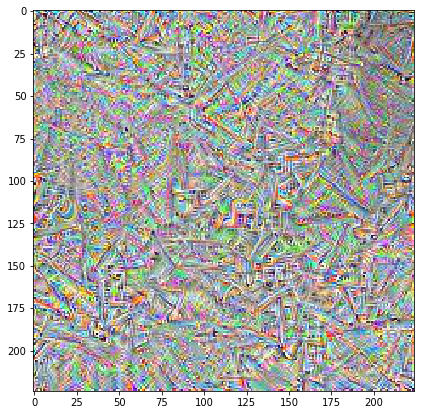

In [12]:
im_path = './generated/layer_vis_l' + str(cnn_layer) + \
                    '_f' + str(filter_pos) + '_iter' + str(30) + '.jpg'
img = Image.open(im_path)
plt.figure(figsize=(7,7))
plt.imshow(img)